# More efficent use of `xarray.open_mfdataset()`

A common workflow associated with data analysis using `xarray` is a "chain"-type workflow, where one operation leads to another, then to another, and so on, until the final result is produced. Each operation produces a `DataSet` or `DataArray` that is a step closer to the final result.

Most workflows of this type have a 'correct' order of operations that will minimise the amount of computation done on the dataset. Running the workflow in the 'wrong' order won't necessarily fail, it may just take longer. Whilst this isn't an issue with smaller models, when analysing the data produced large models like AUS2200, running these operations out-of-order can often result in hangs or crashes.

`xarray` often works like this internally as well. A single `xarray` operation can include a chain of smaller operations that produce the desired result. `xarray.open_mfdataset()` is one of these operations, internally consisting of a series of `xarray.open_dataset()` operations followed by an `xarray.concat()`. These operations can be parallelised over a dask cluster by passing `parallel=True` to `open_mfdataset()`. In some cases, it can provide a worthwhile performance improvement if certain subsetting operations (e.g. picking variables out of datasets) are performed by `open_mfdataset()` directly using the `preprocess` argument.

A standard wokflow using `open_mfdataset()` might look like the following:

In [1]:
import xarray as xr
import glob
import dask
import logging
from dask.distributed import Client

In [2]:
client = Client(threads_per_worker=1,memory_limit=0,silence_logs=logging.ERROR)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37203,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:39201,Total threads: 1
Dashboard: /proxy/41751/status,Memory: 0 B
Nanny: tcp://127.0.0.1:42215,


In [3]:
era5_vert_winds_files=sorted(glob.glob('/g/data/rt52/era5/pressure-levels/monthly-averaged/w/20*/*.nc'))
ds=xr.open_mfdataset(era5_vert_winds_files,parallel=True)
ds

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, level: 37, time: 278)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * level      (level) int32 1 2 3 5 7 10 20 30 ... 850 875 900 925 950 975 1000
  * time       (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2023-02-01
Data variables:
    w          (time, level, latitude, longitude) float32 dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    license:      Licence to use Copernicus Products: https://apps.ecmwf.int/...
    summary:      ERA5 is the fifth generation ECMWF atmospheric reanalysis o...
    title:        ERA5 pressure-levels monthly-averaged vertical_velocity 200...
    history:      2020-11-06 00:34:01 UTC+1100 by era5_replication_tools-1.5....

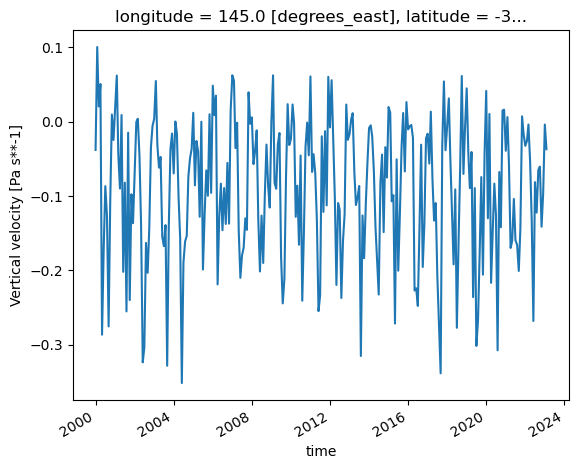

In [4]:
### Pick out the 850hPa pressure level
ds_850=ds.sel(level=850)
### Pick out the grid point corresponding to Melbourne
ds_850_mel=ds_850.sel(latitude=-37.81, longitude=144.96, method='nearest')
ds_850_mel['w'].plot()

Now, this is a fairly contrived example, but it does highlight the idea behind the 'chain' workflow. The dataset files are opened, then concatenated, then a pressure level is picked out, followed by a single point. With the `preprocess`, we can change the order of operations within the workflow and arrive at the same result.

In [5]:
def _preprocess(ds):
    return ds.sel(level=850,latitude=-37.81, longitude=144.96, method='nearest')
era5_vert_winds_files=glob.glob('/g/data/rt52/era5/pressure-levels/monthly-averaged/w/20*/*.nc')
ds_850_mel=xr.open_mfdataset(era5_vert_winds_files,parallel=True,preprocess=_preprocess)
ds_850_mel

<xarray.Dataset>
Dimensions:    (time: 278)
Coordinates:
    longitude  float32 145.0
    latitude   float32 -37.75
    level      int32 850
  * time       (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2023-02-01
Data variables:
    w          (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    license:      Licence to use Copernicus Products: https://apps.ecmwf.int/...
    summary:      ERA5 is the fifth generation ECMWF atmospheric reanalysis o...
    title:        ERA5 pressure-levels monthly-averaged vertical_velocity 200...
    history:      2020-11-06 00:34:01 UTC+1100 by era5_replication_tools-1.5....

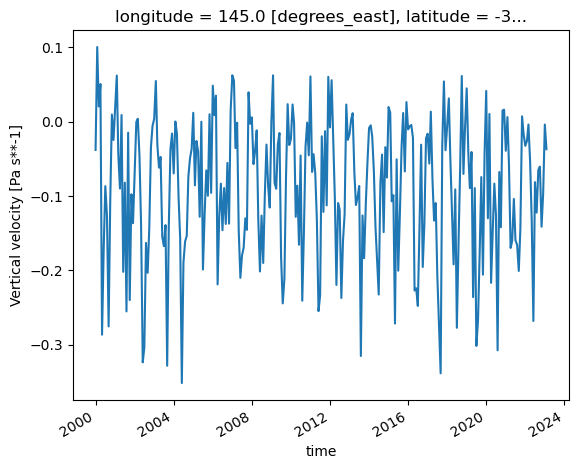

In [6]:
ds_850_mel['w'].plot()

The `preprocess` argument to `mf_dataset` takes a function that takes a single `xarray` `DataSet` as its argument, and can return either a `DataSet` or `DataArray`. The function given as the `preprocess` argument will then operate on every dataset from each file passed to `open_mfdataset` before the concatenation occurs. In this example, its more efficient to perform the `sel` after `open_mfdataset`, however that isn't always the case.

## AUS2200 model output data

The raw output from the AUS2200 model is directly converted to netCDF from the UM Fields File format, and as such, contains many different fields in the same file. Often, the same file can contain fields with different grid types and different time scales. As a 2.2km atmosphere model, the size of these datasets is also rather large. A single hourly output file weighs in at around 8GB of compressed netCDF, so constructing time-series data can involve reading over multiple TB of files. For this example, we'll plot surface temperature of a single point in a 2-week model run at 10 minute intervals from hourly files. This involves reading from 336 files, each containing 39 variables, with 2 different grid projections, 2 different time scales and a pseudo level coordinate that is only applied to 3 fields.

In [7]:
%%time
ds=xr.open_dataset('/g/data/hh5/tmp/WACI-Hackathon-2023/AUS2200/flood22-barra-soil-24hspinup/atmos/umnsa_spec_20220222T0000_10min.nc')
ds.fld_s00i024

CPU times: user 1.57 s, sys: 168 ms, total: 1.74 s
Wall time: 1.76 s


<xarray.DataArray 'fld_s00i024' (time: 6, lat: 2120, lon: 2600)>
[33072000 values with dtype=float32]
Coordinates:
  * time                      (time) datetime64[ns] 2022-02-22T00:10:00 ... 2...
  * lat                       (lat) float64 -48.79 -48.77 ... -6.852 -6.832
  * lon                       (lon) float64 107.5 107.5 107.6 ... 159.0 159.0
    theta_level_height        float64 ...
    model_theta_level_number  int32 ...
    sigma_theta               float64 ...
    height                    float64 ...
    height_0                  float64 ...
Attributes:
    standard_name:    surface_temperature
    long_name:        SURFACE TEMPERATURE AFTER TIMESTEP
    units:            K
    um_stash_source:  m01s00i024
    grid_mapping:     latitude_longitude

In [8]:
%%time
aus2200_file_list=sorted(glob.glob('/g/data/hh5/tmp/WACI-Hackathon-2023/AUS2200/flood22-barra-soil-24hspinup/atmos/umnsa_spec_*.nc'))
### Need this to prevent many warning messages
with dask.config.set(**{'array.slicing.split_large_chunks':False}):
    ds=xr.open_mfdataset(aus2200_file_list,chunks={'time': 6, 'time_0':6, 'lat':414, 'lon':520},parallel=True,combine="nested",concat_dim=["time"])
ds

CPU times: user 1min 12s, sys: 4.99 s, total: 1min 17s
Wall time: 1min 24s


<xarray.Dataset>
Dimensions:                   (lat: 2120, lon: 2600, pseudo_level: 5,
                               lon_0: 2600, lat_0: 2121, time_0: 2016,
                               time: 2016, bnds: 2)
Coordinates:
  * lat                       (lat) float64 -48.79 -48.77 ... -6.852 -6.832
  * lon                       (lon) float64 107.5 107.5 107.6 ... 159.0 159.0
  * pseudo_level              (pseudo_level) int32 1 2 3 4 5
  * lon_0                     (lon_0) float64 107.5 107.5 107.5 ... 159.0 159.0
  * lat_0                     (lat_0) float64 -48.8 -48.78 ... -6.842 -6.822
  * time_0                    (time_0) datetime64[ns] 2022-02-22T00:05:00 ......
  * time                      (time) datetime64[ns] 2022-02-22T00:10:00 ... 2...
    theta_level_height        float64 5.0
    model_theta_level_number  int32 1
    sigma_theta               float64 0.9994
    height                    float64 10.0
    height_0                  float64 1.5
Dimensions without coordinates: bnds
Data variables: (12/39)
    fld_s00i010               (time, lat, lon) float32 dask.array<chunksize=(6, 414, 520), meta=np.ndarray>
    latitude_longitude        (time) int32 -2147483647 ... -2147483647
    lat_bnds                  (time, lat, bnds) float64 dask.array<chunksize=(6, 414, 2), meta=np.ndarray>
    lon_bnds                  (time, lon, bnds) float64 dask.array<chunksize=(6, 520, 2), meta=np.ndarray>
    theta_level_height_bnds   (time, bnds) float64 dask.array<chunksize=(6, 2), meta=np.ndarray>
    sigma_theta_bnds          (time, bnds) float64 dask.array<chunksize=(6, 2), meta=np.ndarray>
    ...                        ...
    fld_s21i101               (time, lat, lon) float64 dask.array<chunksize=(6, 414, 520), meta=np.ndarray>
    fld_s21i104               (time, time_0, lat, lon) float32 dask.array<chunksize=(6, 2016, 414, 520), meta=np.ndarray>
    fld_s30i403               (time, lat, lon) float32 dask.array<chunksize=(6, 414, 520), meta=np.ndarray>
    fld_s30i404               (time, lat, lon) float32 dask.array<chunksize=(6, 414, 520), meta=np.ndarray>
    fld_s30i405               (time, lat, lon) float32 dask.array<chunksize=(6, 414, 520), meta=np.ndarray>
    fld_s30i406               (time, lat, lon) float32 dask.array<chunksize=(6, 414, 520), meta=np.ndarray>
Attributes:
    history:      File /home/563/dr4292/cylc-run/u-cs142-24hspinup-barrasmc-2...
    Conventions:  CF-1.6
    source:       Data from Met Office Unified Model
    um_version:   12.2

CPU times: user 4.53 s, sys: 383 ms, total: 4.92 s
Wall time: 25.5 s


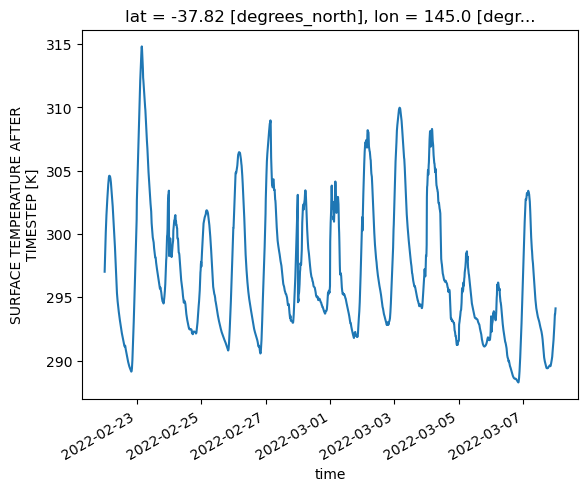

In [9]:
%%time
da_surface_temp_melb=ds['fld_s00i024'].sel(lat=-37.81, lon=144.96, method='nearest')
da_surface_temp_melb.plot()

Note that it takes quite a bit of careful tuning and options passed to `open_mfdataset` to get a sensible `DataSet` out at all. Just running `open_mfdataset` with none of these settings takes twice as long, results in several thousand lines of warning messages about large chunks, and fails to handle the two overlapping time dimensions in the files correctly, resulting in every variable being defined over both time dimensions. That's all before the surface temperature plot is created. The timings in this notebook are based on a 'medium' sized job on the `normal` queue. When I ran the workflow with the unoptimised `open_mfdataset` call on an 'xxxlarge' sized job in the `normalsr` queue, it crashed before creating the average temperature plot due to exceeding the node's memory limit of 496GB.

I spent about half a day coming up with the tuning settings used in `open_mfdataset`. These settings are not generic either, a different dataset will required different parameters to be opened correctly. In fact, different variables within the AUS2200 dataset will require different settings. 

All of this can be avoided by writing a one line function and using `preprocess` to pick out the surface temperature dataset from the beginning.

In [10]:
### Free up memory
del(ds)

In [11]:
%%time
def _preprocess(ds):
    return ds['fld_s00i024']
ds_preprocess=xr.open_mfdataset(aus2200_file_list,preprocess=_preprocess,parallel=True)
ds_preprocess

CPU times: user 54.5 s, sys: 4.14 s, total: 58.6 s
Wall time: 1min 4s


<xarray.Dataset>
Dimensions:                   (time: 2016, lat: 2120, lon: 2600)
Coordinates:
  * time                      (time) datetime64[ns] 2022-02-22T00:10:00 ... 2...
  * lat                       (lat) float64 -48.79 -48.77 ... -6.852 -6.832
  * lon                       (lon) float64 107.5 107.5 107.6 ... 159.0 159.0
    theta_level_height        float64 5.0
    model_theta_level_number  int32 1
    sigma_theta               float64 0.9994
    height                    float64 10.0
    height_0                  float64 1.5
Data variables:
    fld_s00i024               (time, lat, lon) float32 dask.array<chunksize=(6, 2120, 2600), meta=np.ndarray>

CPU times: user 2.63 s, sys: 232 ms, total: 2.86 s
Wall time: 15.7 s


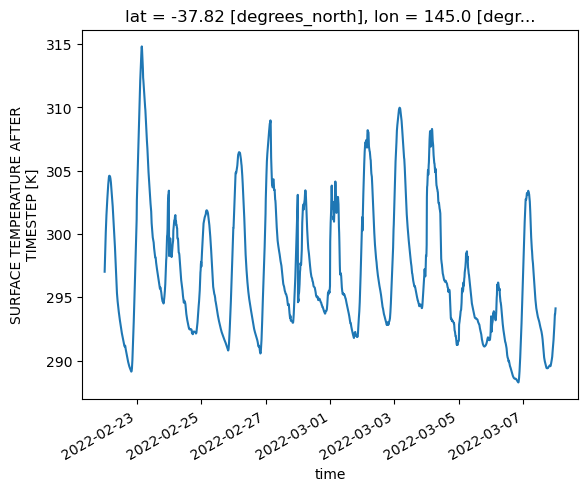

In [12]:
%%time
ds_preprocess['fld_s00i024'].sel(lat=-37.81, lon=144.96, method='nearest').plot()

## Summary

In total, there is about a 25% reduction in runtime in generating this surface temperature plot. But more importantly than the 30 seconds of walltime saved, there is the potential to save a lot of time iterating over various chunk sizes and `xarray` settings attempting to have it correctly concatenate a large and complex dataset. Using `preprocess` to change the order of operations within `open_mfdataset` can significantly reduce resource usage when compared to a naive `open_mfdataset` call, or can reduce the time you spend trying to get `xarray` to do what you need it to.